# M1969 Tarea 1 implementación mlp 1 capa oculta con backprop

## Alumno: Gerardo de Miguel González

### Descripción

```r
lin<-read.csv(”circle.csv",header = F)
a<-as.matrix(lin[,-3])
b<-as.matrix(lin[,3])
backprop_mlp(a,b, h=5, epochs = 500, eta = 0.1)
# h: hidden neurons
```

**TAREA (los BONUS 1 y 2 son opcionales):**

Generalizar la función `backprop` anterior para que contemple la inclusión de
una capa oculta. Aplicar la función al ejemplo de la clasificación circular.
Si se fija el número máximo de épocas en 1000. ¿Qué número de neuronas
ocultas y qué valor de la tasa de aprendizaje (eta) es óptimo para este
problema? (basta una solución aproximada).

BONUS 1- ¿Sabrías incluir un término de inercia en el método de
backpropagation (ver transparencia 4)?

BONUS 2- Generalizar a un número arbitrario de capas (recomendación,
definir los pesos como una lista de matrices, una para cada capa).

### Dataset Circular

In [1]:
#::GMG::Cargo los datos del problema no lineal (nube de puntos ejemplo)
circle <- read.csv('data/circle.csv', header = F)

In [2]:
#::GMG::Acondiciono el dataset
# https://stackoverflow.com/questions/6081439/changing-column-names-of-a-data-frame
colnames(circle) <- c('x1', 'x2', 'class')
#circle$class <-  as.factor(circle$class)
#levels(circle$class) <- c('outside', 'inside')
str(circle)

'data.frame':	100 obs. of  3 variables:
 $ x1   : num  -0.9719 -0.553 -0.0949 -0.8096 0.399 ...
 $ x2   : num  0.847 -0.577 -0.299 0.857 0.69 ...
 $ class: int  0 0 1 0 0 0 0 0 0 0 ...


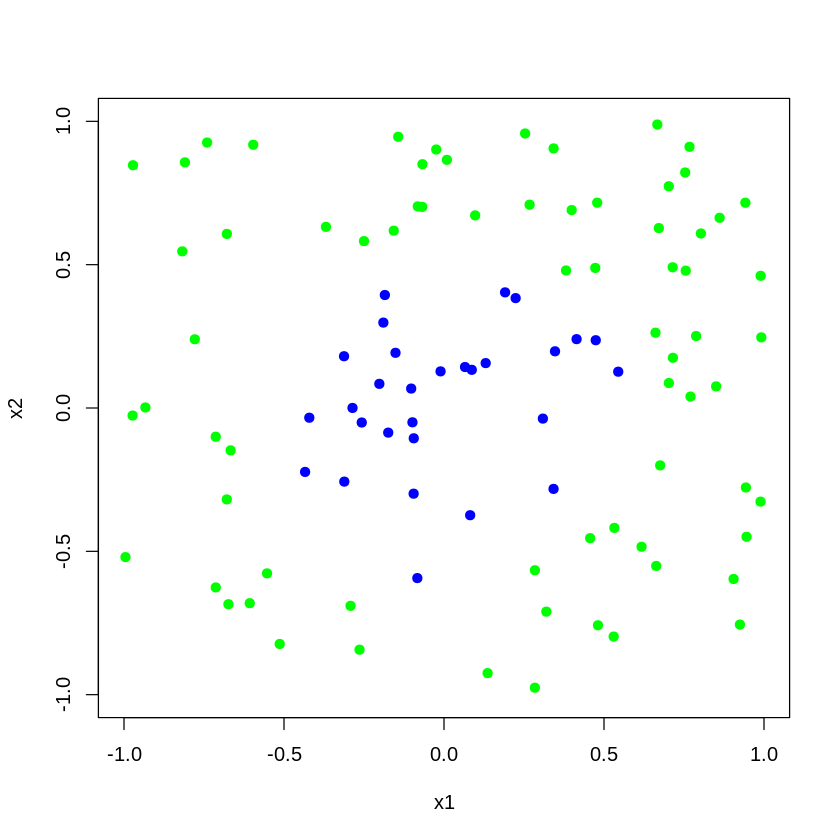

In [3]:
#::GMG::Visualización del dataset circular
ind_c <- which(circle[,'class']==0)
#plot(circle[ind_out,'x1'],circle[ind_out,'x2'],
plot(circle[ind_c,'x1'],circle[ind_c,'x2'],
     type='p',
     xlim=c(-1,1),ylim=c(-1,1), 
     xlab = 'x1', ylab = 'x2',
     col = 'green', pch = 19)
#points(circle[ind_in,'x1'],circle[ind_in,'x2'],
points(circle[-ind_c,'x1'],circle[-ind_c,'x2'],
      col='blue', pch = 19)

### Generalización

In [4]:
#::GMG::Elijo la función de activación que voy a aplicar 
#       a las neuronas ocultas y de salida (S8-S10, S01-Intro-FeedForward.pdf)
#::nota:: f'(x) = f(x) (1 - f(x)) (S10, S01-Intro-FeedForward.pdf)
sigmoid <- function(z) {
    1/(1 + exp(-z))
}

In [5]:
#::GMG::Implemento el paso FeedForward de una red neuronal con UNA capa oculta
#::nota::output -> resultado de la capa de salida 
#        h -> resultado de la capa oculta
#        w1 -> matriz de pesos de entrada a capa oculta
#        w2 -> matriz de pesos de capa oculta a salida
feedforward <- function(x, w1, w2) {
  h <- sigmoid(cbind(1, x) %*% w1)
  o <- sigmoid(cbind(1, h) %*% w2)
  list(output = o, h = h)
}

In [6]:
#::GMG::implemento el algoritmo de aprendizaje backprop con batch gradient descent básico
#::nota::la función de pérdida es la suma de cuadrados (sse)
#::nota::x -> vector (matriz) de muestras de entrada del dataset
#        y -> vector (matriz) de muestras de salida del dataset
#        y_hat -> vector (matriz) de muestras de salida de la red neuronal
#        w1 -> matriz de pesos de entrada a capa oculta
#        w2 -> matriz de pesos de capa oculta a salida
#        h_hat -> vector (matriz) de salida de la capa intermedia
#        learning_rate -> tasa de aprendizaje
backprop <- function(x, y, y_hat, w1, w2, h, learning_rate) {
  error_o <- y - y_hat
  sse <- (t(error_o)%*%error_o)/2
  aux_o <- error_o * (y_hat * (1 - y_hat))  
  #::nota::hack drop FALSE para evitar que R convierta la matriz en vector
  # https://www.datamentor.io/r-programming/matrix/
  # ==> NO! error_h <- aux_o%*%t(w2)
  error_h <- aux_o%*%t(w2[-1, , drop = FALSE]) 
  aux_h <- error_h * (h * (1 - h))
  delta_o <- (t(cbind(1,h))%*%aux_o)
  delta_h <- (t(cbind(1,x))%*%aux_h)
  w2 <- w2 + delta_o*learning_rate
  w1 <- w1 + delta_h*learning_rate

  list(w1 = w1, w2 = w2, error = sse)
}

In [31]:
#::GMG::Implemento la red neuronal mlp (una capa oculta)
#::nota::x -> vector (matriz) de muestras de entrada del dataset
#        y -> vector (matriz) de muestras de salida del dataset
#        h -> número de neuronas en la capa oculta
#        eta -> tasa de aprendizaje
mi_mlp <- function(y, x, h = 5, epochs = 500, eta = 0.1, 
                   x_test = NULL, y_test = NULL) {
  d <- ncol(x) + 1
  w1 <- matrix(rnorm(d * h), d, h)
  w2 <- matrix(rnorm(h + 1), h + 1, 1)
  sse_tr <- list()
  sse_tt <- list()
  for (i in 1:epochs) {
    ff <- feedforward(x, w1, w2)
    bp <- backprop(x, y,
                   y_hat = ff$output,
                   w1, w2,
                   h = ff$h,
                   learning_rate = eta)
    sse_tr[[length(sse_tr)+1]] <- bp$error
    w1 <- bp$w1
    w2 <- bp$w2
    ifelse( is.null(x_test) | is.null (y_test), 
           {
               '# no test'
           }, 
           {
               ff_tt <- feedforward(x_test, w1, w2)
               error_tt <- y_test - ff_tt$output
               sse_tt[[length(sse_tt)+1]] <- (t(error_tt)%*%error_tt)/2
           } 
          )
    
  }
  list(output = ff$output, 
       w1 = w1, 
       w2 = w2,
       error_tr = unlist(sse_tr),
       error_tt = unlist(sse_tt))
}

### Entrenamiento y validación

In [32]:
#::GMG::Reproducibilidad
set.seed(1)

In [33]:
#::GMG::Train/Test del dataset
ind <- sort(sample(nrow(circle), nrow(circle)*.8))
circle_train <- circle[ind,]
circle_test <- circle[-ind,]

In [37]:
#::GMG::Entreno la red neuronal con los hiperparámetros h, epochs y eta
#::nota::incluyo el conjunto de test para hacer la validación del modelo
modelo <- mi_mlp(y = circle_train$class,
                 x = data.matrix(circle_train[, c('x1', 'x2')]), 
                 h = 5, 
                 epochs = 500, 
                 eta = 0.1,
                 x_test = data.matrix(circle_test[, c('x1', 'x2')]), 
                 y_test = circle_test$class)

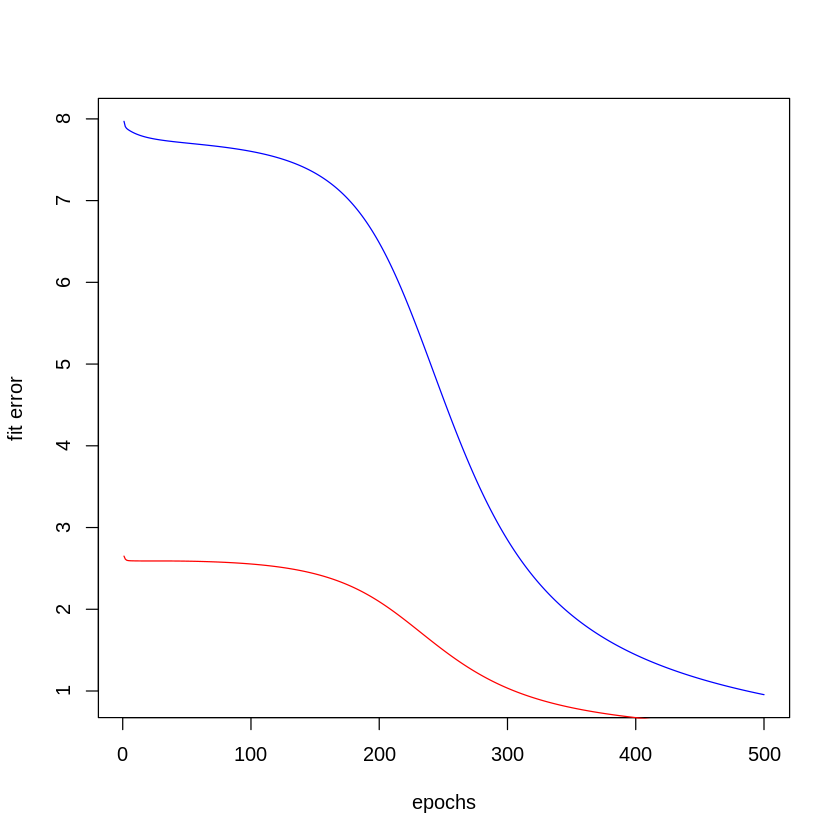

In [51]:
#::GMG::Visualizo el error de entrenamiento y test a lo largo de las épocas
#par(mfrow=c(1,2), mar = c(4,4,1,1))
plot(modelo$error_tr, 
     xlab = 'epochs', ylab = 'fit error', 
     type = 'l', col = 'blue')
points(modelo$error_tt, 
     #xlab = 'epochs', ylab = 'test fit error', 
     type = 'l', col = 'red')

### Visualización de la separación de clases

In [39]:
#::GMG::uso la biblioteca de gráficos avanzados ggplot
library('ggplot2')

In [42]:
#::GMG::Convierto la clase en un factor
circle$class <-  as.factor(circle$class)
levels(circle$class) <- c('outside', 'inside')
str(circle)

'data.frame':	100 obs. of  3 variables:
 $ x1   : num  -0.9719 -0.553 -0.0949 -0.8096 0.399 ...
 $ x2   : num  0.847 -0.577 -0.299 0.857 0.69 ...
 $ class: Factor w/ 2 levels "outside","inside": 1 1 2 1 1 1 1 1 1 1 ...


In [43]:
#::GMG::creo una malla para el dataset
grid <- expand.grid(x1 = seq(min(circle$x1) - .5,
                             max(circle$x1) + .5,
                             by = .0625),
                    x2 = seq(min(circle$x2) - .5,
                             max(circle$x2) + .5,
                             by = .0625))

In [44]:
#::GMG::Paso el dataset por la red neuronal ya entrenada
ff_grid <- feedforward(x = data.matrix(grid[, c('x1', 'x2')]),
                       w1 = modelo$w1,
                       w2 = modelo$w2)
grid$class <- factor((ff_grid$output > .5) * 1,
                     labels = levels(circle$class))

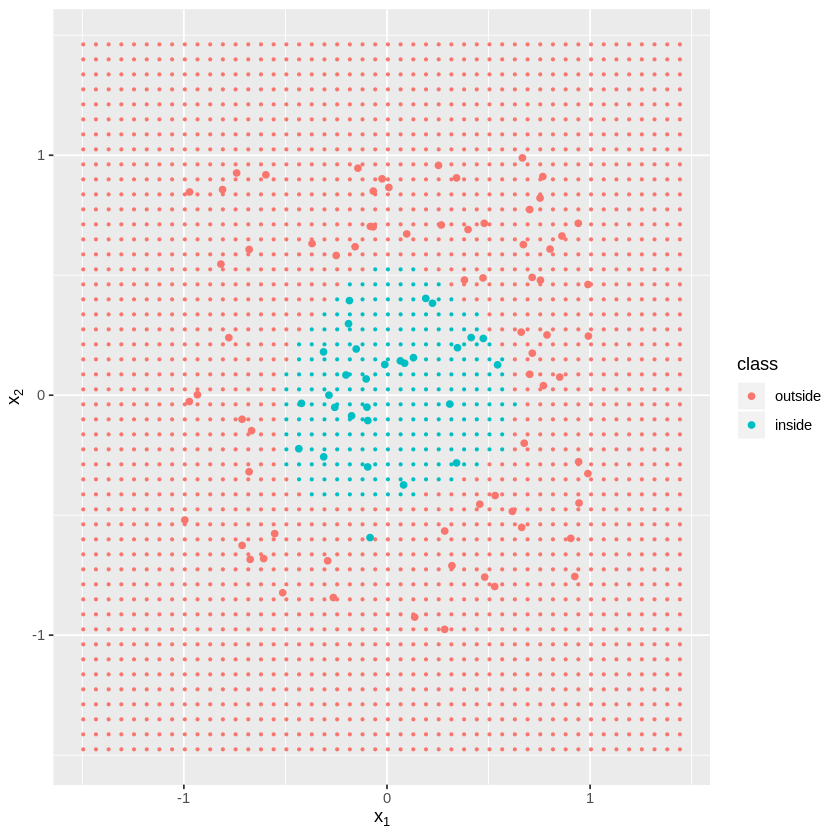

In [45]:
#::GMG::Dibujo el resultado
ggplot(circle) + aes(x1, x2, colour = class) +
  geom_point(data = grid, size = .5) +
  geom_point() +
  labs(x = expression(x[1]), y = expression(x[2]))

### Optimización de hiperparámetros $\eta$ y h

¿Qué número de neuronas ocultas y qué valor de la tasa de aprendizaje (eta) es óptimo para este problema?

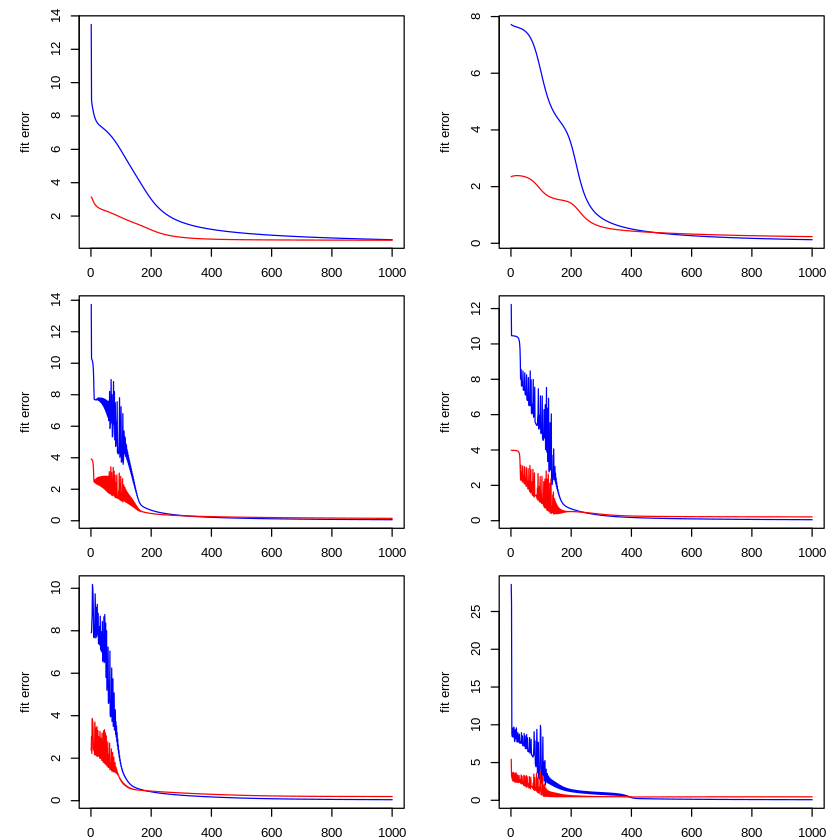

In [50]:
#::GMG::Pruebo con la tasa de aprendizaje
#::nota::uso el método utilizado en la primera sesión de prácticas con RSNNS
par(mar = c(2,5,1,1), mfrow=c(3,2))
for (i in 1:6) {
  model <- mi_mlp(x = data.matrix(circle_train[, c('x1', 'x2')]), 
                  y = circle_train$class,
                  h = 5, 
                  epochs = 1000,
                  eta = i*0.1,
                  x_test = data.matrix(circle_test[, c('x1', 'x2')]), 
                  y_test = circle_test$class
              ) 
  plot(model$error_tr, 
     xlab = 'epochs', ylab = 'fit error', 
     type = 'l', col = 'blue')
  points(model$error_tt, 
     #xlab = 'epochs', ylab = 'test fit error', 
     type = 'l', col = 'red')
}

In [ ]:
#::GMG::Pruebo ahora con las neuronas ocultas pero esta vez uso AUC de la biblioteca verification
